In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

from rpy2.robjects import r

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R -o counts -o cells -o batch

suppressMessages(library(splatter))

params <- newSplatParams()

params <- setParam(params, "nGenes", 2000)
params <- setParam(params, "batchCells", c(1000, 1000, 2000))
params <- setParam(params, "batch.facLoc", 0.3)
params <- setParam(params, "batch.facScale", 0.3)
params <- setParam(params, "group.prob", c(1/4, 1/4, 1/4, 1/4))

sim <- splatSimulate(params, method="groups", verbose=FALSE)

counts <- data.frame(counts(sim))
cells <- colData(sim)[,"Group"]
batch <- colData(sim)[,"Batch"]

In [5]:
counts = np.array(counts)
meta = pd.DataFrame({'cells': cells, 'batch': batch} , dtype="str", index = range(0, len(cells)))

In [6]:
adata = ad.AnnData(X = counts.T, obs = meta)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

Transforming to str index.


In [7]:
adata.uns["batch_colors"] = ["#9b59b6", "#3498db", "#95a5a6"]

... storing 'cells' as categorical
... storing 'batch' as categorical


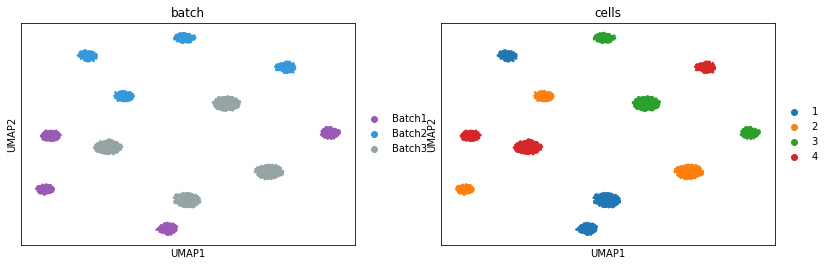

In [8]:
sc.pl.umap(adata,color=['batch','cells'])

In [9]:
adata = adata[np.random.choice(adata.obs_names, adata.shape[0], replace = False)]

In [10]:
from bbtnn.tnn_v3 import *

In [11]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 2, save_on_disk = False)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
2525 cells defined as MNNs
Calculating KNNs
1475 cells defined as KNNs
Re-format


W0330 14:11:30.739204 16064 deprecation.py:323] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4075: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0330 14:11:30.787386 16064 deprecation.py:506] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Training neural network
Epoch 1/1000
125/125 - 2s - loss: 1.6546
Epoch 2/1000
125/125 - 1s - loss: 1.1969
Epoch 3/1000
125/125 - 1s - loss: 0.9490
Epoch 4/1000
125/125 - 1s - loss: 0.7873
Epoch 5/1000
125/125 - 1s - loss: 0.6725
Epoch 6/1000
125/125 - 1s - loss: 0.6087
Epoch 7/1000
125/125 - 1s - loss: 0.5363
Epoch 8/1000
125/125 - 1s - loss: 0.4776
Epoch 9/1000
125/125 - 1s - loss: 0.4594
Epoch 10/1000
125/125 - 1s - loss: 0.4307
Epoch 11/1000
125/125 - 1s - loss: 0.3937
Epoch 12/1000
125/125 - 1s - loss: 0.3866
Epoch 13/1000
125/125 - 1s - loss: 0.3882
Epoch 14/1000
125/125 - 1s - loss: 0.3723
Epoch 15/1000
125/125 - 1s - loss: 0.3747
Epoch 16/1000
125/125 - 1s - loss: 0.3586
Epoch 17/1000
125/125 - 1s - loss: 0.3717
Epoch 18/1000
125/125 - 1s - loss: 0.3434
Epoch 19/1000
125/125 - 1s - loss: 0.3702
Epoch 20/1000
125/125 - 1s - loss: 0.3358
Epoch 21/1000
125/125 - 1s - loss: 0.3362
Epoch 22/1000
125/125 - 1s - loss: 0.3267
Epoch 23/1000
125/125 - 1s - loss: 0.3226
Epoch 24/1000
125/1

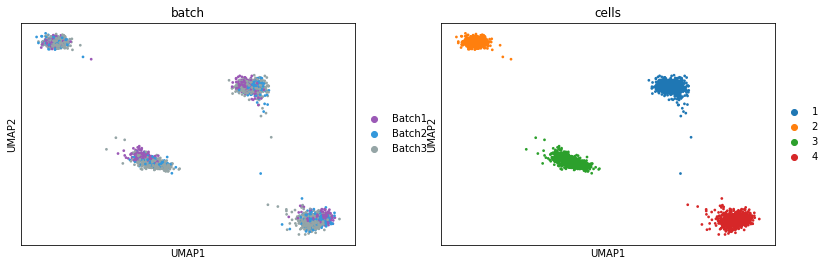

In [12]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

In [13]:
bdata = adata[~((adata.obs["batch"] == "Batch1") & (adata.obs["cells"] =="4"))]
bdata = bdata[~((bdata.obs["batch"] == "Batch2") & (bdata.obs["cells"] =="4"))]

In [14]:
bdata

View of AnnData object with n_obs × n_vars = 3481 × 2000 
    obs: 'cells', 'batch', 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'batch_colors', 'cells_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [15]:
sc.tl.pca(bdata)
sc.pp.neighbors(bdata, n_neighbors=10)
sc.tl.umap(bdata)

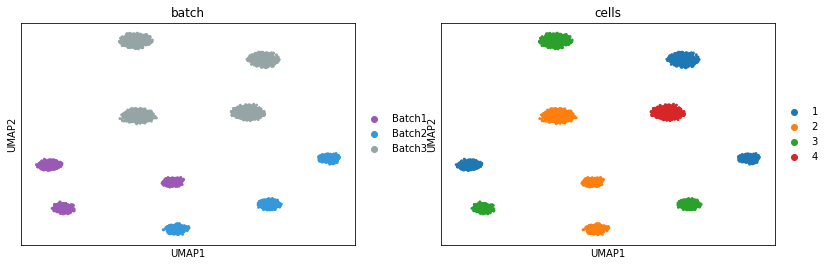

In [16]:
sc.pl.umap(bdata, color = ["batch", "cells"])

In [17]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 0, save_on_disk = False)
model.fit(X = bdata, batch_name = "batch", Y = None)
embedding = model.transform(X = bdata)

Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
Wall time: 16.9 s


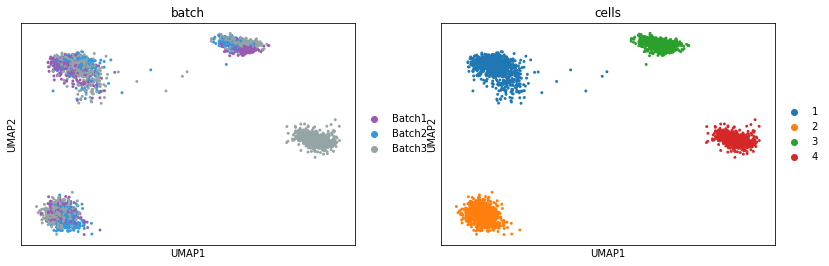

In [18]:
bdata.obsm["X_umap"] = embedding
sc.pl.umap(bdata, color = ["batch", "cells"])

In [31]:
from bbtnn.tnn import *

[[0.    0.345 0.54 ]
 [0.    0.    0.346]
 [0.    0.    0.   ]]
1661
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:4000
******Number of cells for MNN:2339


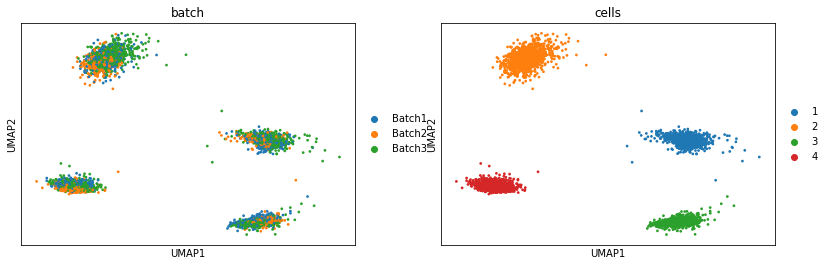

Wall time: 35.1 s


In [34]:
%%time
y_labels = adata.obs["cells"]
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 0,
            supervision_weight=0.9)
model.fit(X = adata, Y = y_labels)
embedding = model.transform(X = adata)
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

[[0.    0.054 0.083]
 [0.    0.    0.03 ]
 [0.    0.    0.   ]]
3647
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:4000
******Number of cells for MNN:353


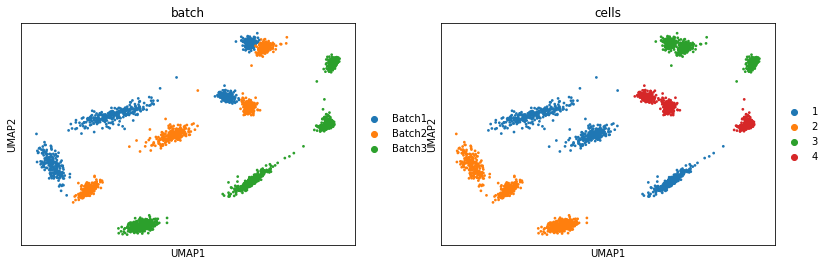

Wall time: 32.4 s


In [35]:
%%time
y_labels = adata.obs["cells"]
model = TNN(k = 5, batch_size = 32, n_epochs_without_progress = 2, verbose = 0)
model.fit(X = adata, Y = None)
embedding = model.transform(X = adata)
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

K = 10
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


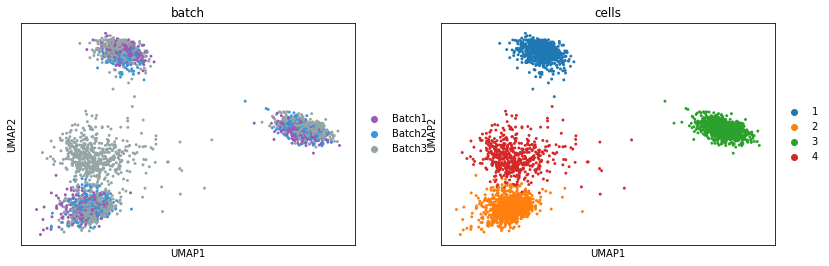

K = 20
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


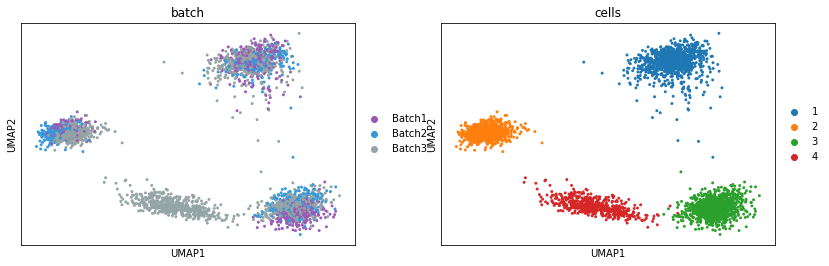

K = 40
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


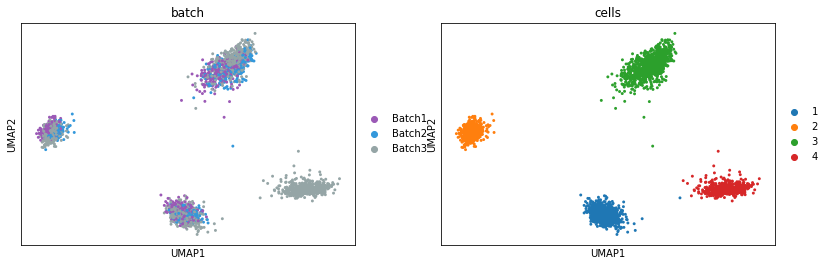

K = 80
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


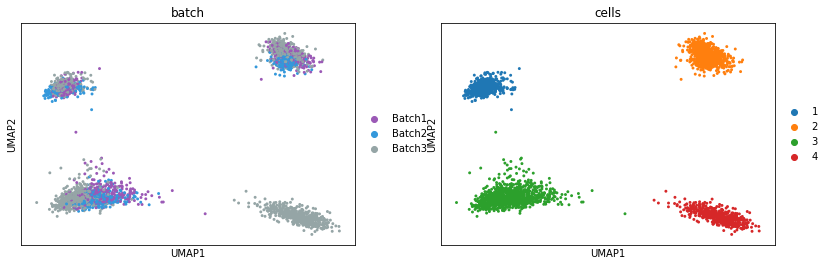

K = 160
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


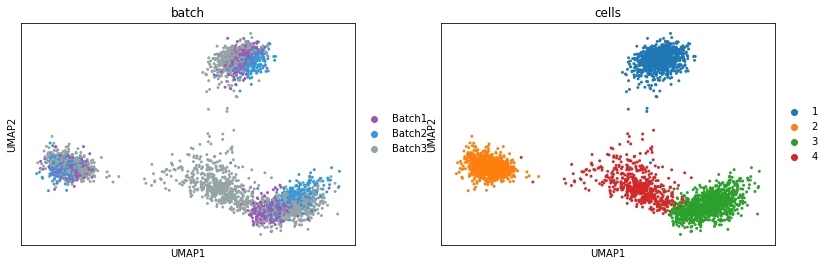

K = 320
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


RuntimeError: Cannot return the results in a contigious 2D array. Probably ef or M is to small

In [19]:
from bbtnn.tnn_v3 import *
for k in [10, 20, 40, 80, 160, 320]:
    print("K = " + str(k))
    model = TNN(k = k, batch_size = 32, n_epochs_without_progress = 2, verbose = 0, save_on_disk=False)
    model.fit(X = bdata, batch_name = "batch", Y = None)
    embedding = model.transform(X = bdata)
    bdata.obsm["X_umap"] = embedding
    sc.pl.umap(bdata, color = ["batch", "cells"])

[[0.         0.0704607  0.16531165]
 [0.         0.         0.0551817 ]
 [0.         0.         0.        ]]
2980
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:3481
******Number of cells for MNN:501


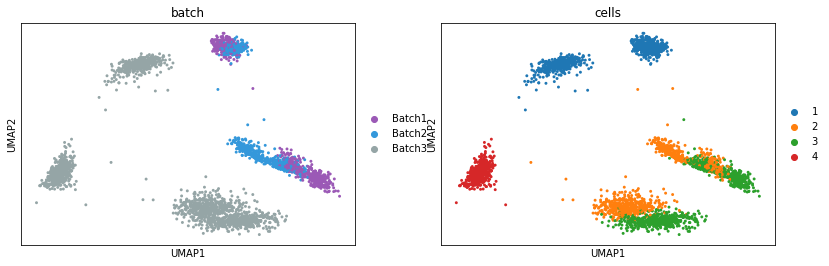

[[0.         0.12737127 0.29674797]
 [0.         0.         0.12382234]
 [0.         0.         0.        ]]
2505
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:3481
******Number of cells for MNN:976


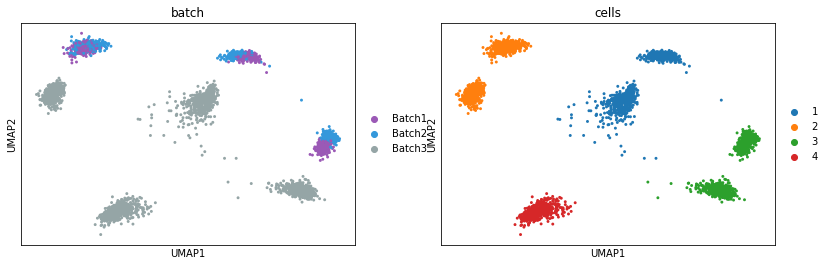

[[0.         0.22086721 0.5       ]
 [0.         0.         0.23553163]
 [0.         0.         0.        ]]
1926
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:3481
******Number of cells for MNN:1555


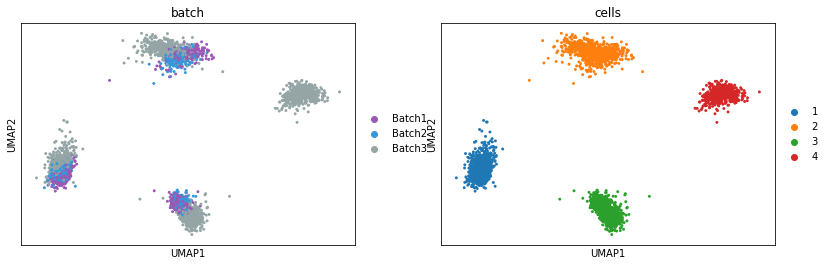

[[0.         0.56639566 0.69918699]
 [0.         0.         0.55316285]
 [0.         0.         0.        ]]
1318
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:3481
******Number of cells for MNN:2163


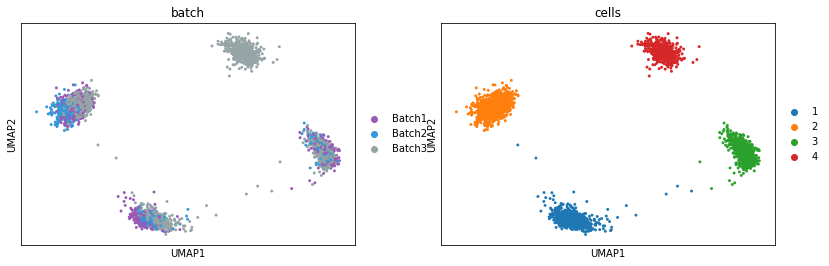

[[0.         0.86314363 0.86449864]
 [0.         0.         0.85060565]
 [0.         0.         0.        ]]
829
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:3481
******Number of cells for MNN:2652


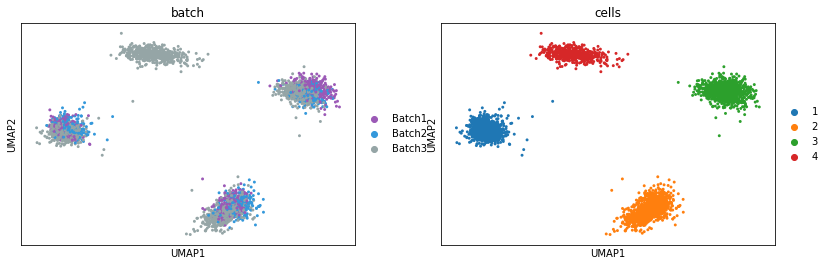

[[0.         0.97154472 0.95392954]
 [0.         0.         0.96096904]
 [0.         0.         0.        ]]
471
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:3481
******Number of cells for MNN:3010


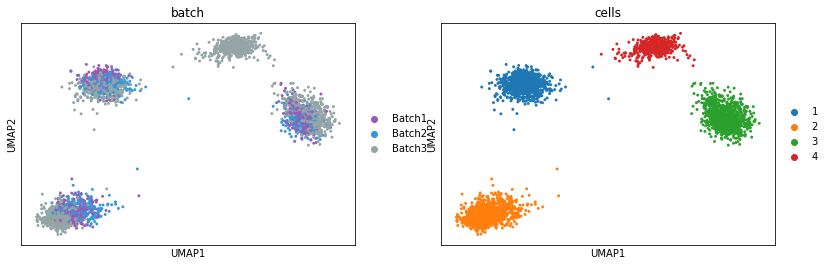

In [21]:
from bbtnn.tnn import *
for k in [10, 20, 40, 80, 160, 320]:
    print("K = " + str(k))
    model = TNN(k = k, batch_size = 32, n_epochs_without_progress = 2, verbose = 0)
    model.fit(X = bdata, Y = None)
    embedding = model.transform(X = bdata)
    bdata.obsm["X_umap"] = embedding
    sc.pl.umap(bdata, color = ["batch", "cells"])

In [12]:
from bbtnn.tnn import *

In [24]:
%%time
model = tnn.TNN(k = 10, batch_size = 32, n_epochs_without_progress = 2, verbose = 2)
model.fit(X = bdata, Y = None)
embedding = model.transform(X = bdata)

[[0.         0.06910569 0.1598916 ]
 [0.         0.         0.0551817 ]
 [0.         0.         0.        ]]
2984
******Batches:[Batch2, Batch3, Batch1]
Categories (3, object): [Batch2, Batch3, Batch1]
******Total number of cells:3481
******Number of cells for MNN:497
Training neural network
Epoch 1/1000
109/109 - 3s - loss: 1.1181
Epoch 2/1000
109/109 - 1s - loss: 0.8498
Epoch 3/1000
109/109 - 1s - loss: 0.7683
Epoch 4/1000
109/109 - 1s - loss: 0.7136
Epoch 5/1000
109/109 - 1s - loss: 0.6968
Epoch 6/1000
109/109 - 1s - loss: 0.6212
Epoch 7/1000
109/109 - 1s - loss: 0.5682
Epoch 8/1000
109/109 - 1s - loss: 0.5067
Epoch 9/1000
109/109 - 1s - loss: 0.4694
Epoch 10/1000
109/109 - 1s - loss: 0.4331
Epoch 11/1000
109/109 - 1s - loss: 0.4065
Epoch 12/1000
109/109 - 1s - loss: 0.3792
Epoch 13/1000
109/109 - 1s - loss: 0.3640
Epoch 14/1000
109/109 - 1s - loss: 0.3514
Epoch 15/1000
109/109 - 1s - loss: 0.3241
Epoch 16/1000
109/109 - 1s - loss: 0.3139
Epoch 17/1000
109/109 - 1s - loss: 0.3128
Ep

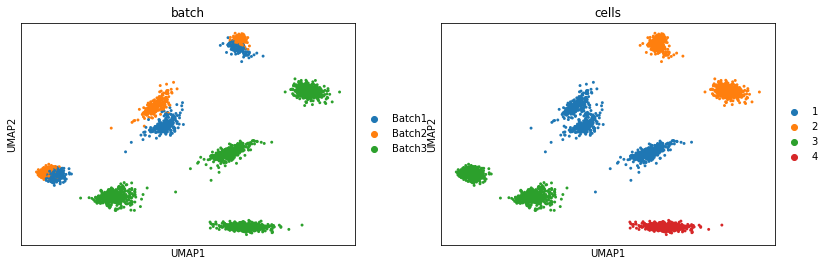

In [25]:
bdata.obsm["X_umap"] = embedding
sc.pl.umap(bdata, color = ["batch", "cells"])